## Servidor Test con Texto

In [ ]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/process-text', methods=['POST'])
def process_text():
    data = request.json  # Obtener datos JSON de la solicitud POST
    if data and 'text' in data:
        text = data['text']  # Obtener la cadena de texto del campo 'text'
        # Puedes realizar cualquier procesamiento deseado en la cadena de texto aquí.
        # Por ejemplo, puedes transformarla a mayúsculas.
        text_uppercase = text.upper()
        
        # Devolver la cadena de texto procesada en formato JSON.
        return jsonify({"processed_text": text_uppercase})
    else:
        return jsonify({"error": "No se ha proporcionado una cadena de texto válida"}), 400

if __name__ == '__main__':
    app.run(debug=False, host='localhost', port=5000)


In [ ]:
%tb

# Procesamiento de la imagen en el servidor

In [ ]:
import cv2
from ultralytics import YOLO

model = YOLO(model='sign_language_1.pt')
classNames = ['A', 'B', 'C', 'D', 'E', 'F', 'G',
              'H', 'I', 'J', 'K', 'L', 'M', 'N', 
              'O', 'P', 'Q', 'R', 'S', 'T', 'U',
              'V', 'W', 'X', 'Y', 'Z']

def process_frame(frame, target_letter, confidence_threshold=0.3):
    # Realiza la detección utilizando el modelo
    results = model(frame, stream=True)
    
    # Para cada detección
    for r in results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            # Filtra las detecciones con una confianza superior al umbral
            if confidence >= confidence_threshold:
                cls = int(box.cls[0])
                
                # Convierte el identificador numérico de la clase a un nombre de clase
                class_name = classNames[cls] if cls < len(classNames) else 'Unknown'
                
                # Verifica si la detección coincide con la letra objetivo
                if class_name == target_letter:
                    return True  # Letra objetivo detectada

    return False  # Letra objetivo no detectada

# Ejemplo de uso
image_path = './assets/test_image_A.jpg'  # Reemplaza con la ruta de tu imagen
target_letter = 'L'  # Reemplaza con la letra objetivo

frame = cv2.imread(image_path)

result = process_frame(frame, target_letter)
print(result)


# Procesamiento de video en el servidor

In [ ]:
import cv2
from ultralytics import YOLO
import numpy as np

def isLetterInVideo(video_path, target_letter, model_path='sign_language_1.pt', confidence_threshold=0.3, percentage_threshold=60):
    model = YOLO(model=model_path)
    classNames = ['A', 'B', 'C', 'D', 'E', 'F', 'G',
                  'H', 'I', 'J', 'K', 'L', 'M', 'N', 
                  'O', 'P', 'Q', 'R', 'S', 'T', 'U',
                  'V', 'W', 'X', 'Y', 'Z']

    # Lista de colores en formato hexadecimal
    colores_hex = ["#09A9F6", "#0045FF", "#4200FF", "#A500FF", "#D600FF", "#FB048F", "#FB3504", 
                   "#FF7800", "#F9BA06", "#9CDF05", "#33B702", "#07900A", "#03C460", "#03BAD5",
                   "#C7570C", "#AEC200", "#414344", "#B800D0", "#0038FF", "#A700AA", "#7D8182",
                   "#0B80F4", "#C809F6", "#C3B500", "#09A9F6", "#5E1EFF", ]

    # Convierte los colores hexadecimales a RGB
    colores_rgb = [(int(col[1:3], 16), int(col[3:5], 16), int(col[5:7], 16)) for col in colores_hex]

    # Crea un diccionario que asigna cada letra a un color en formato RGB
    letras_colores = {letra: color for letra, color in zip(classNames, colores_rgb)}


    
    # Abre el archivo de video
    cap = cv2.VideoCapture(video_path)
    
    # Crea el video de salida con el mismo nombre pero con "output_" como prefijo
    output_video_path = video_path.replace(video_path.split('/')[-1], f"output_{video_path.split('/')[-1]}")
    fourcc = cv2.VideoWriter_fourcc(*'H264')
    out = cv2.VideoWriter(output_video_path, fourcc, 30, (int(cap.get(3)), int(cap.get(4))))
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    detected_frames = 0

    
    while True:
        ret, img = cap.read()
        
        if ret:
            # Realiza la detección utilizando el modelo
            results = model(img, stream=True)

            # Para cada detección
            for r in results:
                boxes = r.boxes
                for box in boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    confidence = box.conf[0]

                    # Filtra las detecciones con una confianza superior al umbral
                    if confidence >= confidence_threshold:
                        cls = int(box.cls[0])

                        # Convierte el identificador numérico de la clase a un nombre de clase
                        class_name = classNames[cls] if cls < len(classNames) else 'Unknown'

                        # Verifica si la clase detectada es la letra objetivo
                        if class_name == target_letter:
                            detected_frames += 1
                            
                        # Dibuja el rectángulo de fondo del texto
                        cv2.rectangle(img, (x1, y1 - 35), (x2, y1), color=letras_colores[class_name], thickness=-1)  # -1 para rellenar el rectángulo
                        cv2.rectangle(img, (x1, y1), (x2, y2), color=letras_colores[class_name] , thickness=2)
                        # Dibuja el texto en el recuadro de fondo
                        cv2.putText(img, f"{class_name} {confidence:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), thickness=2)

            # Escribe el frame procesado en el video de salida
            out.write(img)
        else:
            break

    # Libera la cámara y cierra las ventanas abiertas
    cap.release()
    cv2.destroyAllWindows()
        
    # Guarda el video de salida
    out.release()
    # Calcula el porcentaje de detección de la letra objetivo
    detection_percentage = (detected_frames / total_frames) * 100

    # Retorna True si el porcentaje es superior al umbral, False en caso contrario
    return detection_percentage >= percentage_threshold

# Ejemplo de uso de la función
input_video_path = './assets/test_video_a.mp4'
target_letter = 'A'

result = isLetterInVideo(input_video_path, target_letter)
print(f"¿Se detectó la letra {target_letter} en más del 60% del video?: {result}")

## Servidor con imagen y video

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://10.22.146.19:5000
Press CTRL+C to quit
C:\Users\Admin\AppData\Local\Temp\ipykernel_13704\2865879003.py:23: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = cv2.imdecode(np.fromstring(file.read(), np.uint8), cv2.IMREAD_UNCHANGED)


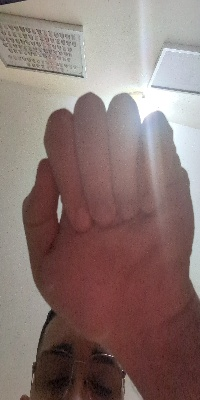

10.22.146.33 - - [13/Jan/2024 20:56:46] "POST /process-image HTTP/1.1" 200 -


Detected letter A on image ? True


In [13]:
from flask import Flask, jsonify, request
import cv2, os
import numpy as np
from IPython.display import Image, display
from werkzeug.utils import secure_filename



app = Flask(__name__)

# Ruta para procesar la imagen

# Ruta para procesar la imagen
@app.route('/process-image', methods=['POST'])
def process_image():
    # Verifica si se ha enviado un archivo de imagen en la solicitud
    if 'image' not in request.files:
        return jsonify({"error": "No se ha proporcionado una imagen válida"}), 400

    file = request.files['image']
    
   # Lee la imagen desde el archivo
    image = cv2.imdecode(np.fromstring(file.read(), np.uint8), cv2.IMREAD_UNCHANGED)
    
    # Rotar la imagen 90 grados en sentido horario
    image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    # Muestra la imagen utilizando OpenCV
    # cv2.imshow('Received Image', image)  
    # Muestra la imagen como un output de la celda
    display(Image(data=cv2.imencode('.jpg', cv2.resize(image, (300, 400)))[1]))   
        
    # Procesa la imagen utilizando tu script de OpenCV
    target_letter = request.form.get('target_letter')  # Obtiene la letra objetivo de la solicitud
    result = process_frame(image, target_letter)  # Llama a la función que procesa la imagen
    print("Detected letter", target_letter, "on image ?", result)
    
    # Devuelve el resultado (True o False) como respuesta
    return jsonify({"result": result})

# Ruta para procesar el video
@app.route('/process-video', methods=['POST'])
def process_video():
    # Verifica si se ha enviado un archivo de vídeo en la solicitud
    if 'video' not in request.files:
        return jsonify({"error": "No se ha proporcionado un video válido"}), 400

    video_file = request.files['video']
    
    # Guarda el video de manera segura y temporal
    filename = secure_filename(video_file.filename)
    temp_video_path = os.path.join('./tmp', filename)
    
    video_file.save(temp_video_path)
    # Después de guardar el archivo
    print(f"Archivo guardado con éxito: {temp_video_path}")
    
    # Procesa la imagen utilizando tu script de OpenCV
    target_letter = request.form.get('target_letter')  # Obtiene la letra objetivo de la solicitud
    result = isLetterInVideo(temp_video_path, target_letter)
 
    # Elimina el archivo de video después de procesar
    # os.remove(temp_video_path)
    print("Detected letter", target_letter, "on video ?", result)
    
    # Devuelve alguna respuesta
    return jsonify({"result": result})

if __name__ == '__main__':
    app.run(debug=False, host='10.22.146.19', port=5000) # Antes localhost
    # Wifi Principal: 10.22.146.19
    # Wifi Movil: 192.168.194.99
    
